In [6]:
import matplotlib
from radmc3dPy.image import *
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pylab as plb

/home/reu24/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [19]:
def plotImage2(image=None, flux=0, arcsec=False, au=False, log=False, dpc=None, maxlog=None, saturate=None, bunit='norm', \
        ifreq=0, cmask_rad=None, interpolation='nearest', cmap=plb.cm.gist_gray, stokes='I', **kwargs):
    pc   = 3.08572e18
# Check whether or not we need to mask the image
    dum_image = copy.deepcopy(image)
    if dum_image.stokes:
        if stokes.strip().upper()=='I':
            if dum_image.nwav==1:
                dum_image.image = image.image[:,:,0]
            else:
                dum_image.image = image.image[:,:,0,:]

        if stokes.strip().upper()=='Q':
            if dum_image.nwav==1:
                dum_image.image = image.image[:,:,1]
            else:
                dum_image.image = image.image[:,:,1,:]

        if stokes.strip().upper()=='U':
            if dum_image.nwav==1:
                dum_image.image = image.image[:,:,2]
            else:
                dum_image.image = image.image[:,:,2,:]
        if stokes.strip().upper()=='V':
            if dum_image.nwav==1:
                dum_image.image = image.image[:,:,2]
            else:
                dum_image.image = image.image[:,:,2,:]
        if stokes.strip().upper()=='PI':
            if dum_image.nwav==1:
                dum_image.image = np.sqrt(image.image[:,:,1]**2 + image.image[:,:,2]**2)
            else:
                dum_image.image = np.sqrt(image.image[:,:,1,:]**2 + image.image[:,:,2,:]**2)
    if cmask_rad!=None:
        dum_image = cmask(dum_image, rad=cmask_rad, au=au, arcsec=arcsec, dpc=dpc)
    else:
        dum_image = dum_image
    if (ifreq==None):
        ifreq = 0
    #data = np.squeeze(dum_image.image[::-1,:,ifreq])
    data = np.squeeze(dum_image.image[:,::-1,ifreq].T)
    #if (image.nfreq>1):
        #if (ifreq==None):
            #ifreq = 0
        #data = squeeze(dum_image.image[::-1,:,ifreq])
    #else:
        #data = dum_image.image[::-1,:]
    norm  = data.max()
    if (bunit=='norm'):
        data = data/norm

    clipnorm = data.max()
# Check if the data should be plotted on a log scale
    if log:
        clipmin = np.log10(data[data>0.].min())
        data = np.log10(data.clip(1e-90))
# Clipping the data
        if (maxlog!=None):
            clipmin = -maxlog + np.log10(clipnorm)
    else:
        clipmin  = data.min()
    if (saturate!=None):
        if (saturate>1.):
            saturate = 1.0
        if log:
            clipmax = np.log10(saturate) + np.log10(clipnorm)
        else:
            clipmax = clipnorm * saturate
    else:
        clipmax = clipnorm
    data = data.clip(clipmin, clipmax)
# Select the unit of the data
    if (bunit=='norm'):
        if log:
            cb_label = 'log(I'+r'$_\nu$'+'/max(I'+r'$_\nu$'+'))'
        else:
            cb_label = 'I'+r'$_\nu$'+'/max(I'+r'$_\nu$'+')'
    elif (bunit=='inu'):
        if log:
            cb_label = 'log(I'+r'$_\nu$'+' [erg/s/cm/cm/Hz/ster])'
        else:
            cb_label = 'I'+r'$_\nu$'+' [erg/s/cm/cm/Hz/ster]'
    elif (bunit=='snu'):
        if dpc==None:
            print('ERROR')
            print(' If Jy/pixel is selected for the image unit the dpc keyword should also be set')
            return
        else:
            if log:
                if len(image.fwhm)>0:
                    data    = data + np.log10(1e23)
                    cb_label = 'log(S'+r'$_\nu$'+ '[Jy/beam])'
                else:
                    data    = data + np.log10(image.sizepix_x * image.sizepix_y / (dpc*pc)**2. * 1e23)
                    cb_label = 'log(S'+r'$_\nu$'+ '[Jy/pixel])'
            else:
                if len(image.fwhm)>0:
                    data    = data * 1e23
                    cb_label = 'S'+r'$_\nu$'+' [Jy/beam]'
                else:
                    data    = data * (image.sizepix_x * image.sizepix_y / (dpc*pc)**2. * 1e23)
                    cb_label = 'S'+r'$_\nu$'+' [Jy/pixel]'
    else:
        print('ERROR')
        print('Unknown image unit : '+bunit)
        return
# Set the color bar boundaries
    if log:
        cb_bound = (data.max(), data.min())
    else:
        cb_bound = (data.min(), data.max())
# Select the coordinates of the data
    if au:
        x = image.x/1.496e13
        y = image.y/1.496e13
        xlab = 'X [AU]'
        ylab = 'Y [AU]'
    elif arcsec:
        x = image.x/1.496e13/dpc
        y = image.y/1.496e13/dpc
        xlab = 'RA offset ["]'
        ylab = 'DEC offset ["]'
    else:
        x = image.x
        y = image.y
        xlab = 'X [cm]'
        ylab = 'Y [cm]'
    ext = (x[0], x[image.nx-1], y[0], y[image.ny-1])
# Now finally put everything together and plot the data
    plb.delaxes()
    plb.delaxes()
    #if (cmap==None):
        #cmap = cm.gist_gray
#    implot = imshow(data, extent=ext, cmap=cm.gist_gray)
    implot = plb.imshow(data, extent=ext, cmap=cmap, interpolation=interpolation, **kwargs)
    plb.xlabel(xlab)
    plb.ylabel(ylab)
    plb.title(r'$\lambda$='+("%.5f"%image.wav[ifreq])+r'$\mu$m, F='+str(flux)+'Jy')
    cbar = plb.colorbar(implot)
    cbar.set_label(cb_label)
    plb.show()
    return {'implot':implot, 'cbar':cbar}

Reading image.out


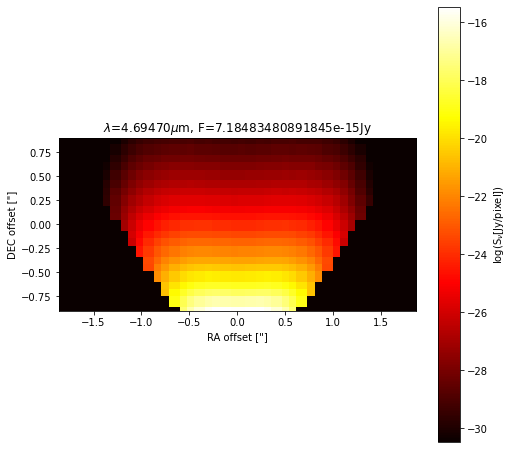

In [23]:
distance = 140 #pc

fig1=plt.figure(figsize=(8,8))
plt.ioff()

img = readImage() 

im_nx, im_ny = img.nx, img.ny # number of pixels on each axis
pixsize_x, pixsize_y = img.sizepix_x, img.sizepix_y # pixel sizes in cm (radians?)
dA = (pixsize_x * pixsize_y)/((distance*3.086e18)**2) # size of each pixel in steradians

image_data = img.image.flatten()
total_flux = np.sum(image_data)*dA*1e23 #summed intensity converted to flux in Jy    
    
result = plotImage2(img, flux=total_flux, log=True, maxlog=15, cmap=cm.hot, bunit='snu', dpc=distance, arcsec=True)

plt.savefig('output.png')
plt.close()

In [99]:
(pixsize_x/1.496E13)/(distance)

0.10147783251231526